<a href="https://colab.research.google.com/github/data3rr0r/Draw-SkewT-LogP-Diagram/blob/main/%EC%A7%80%EA%B5%AC%EA%B3%BC%ED%95%992_%EB%8B%A8%EC%97%B4%EC%84%A0%EB%8F%84_%EA%B7%B8%EB%A6%AC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# 모듈 설치 및 불러오기
!pip install metpy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [61]:
# 고층 관측 데이터 불러오기
# 여기서는 본인의 Google Drive의 '지구과학데이터' 폴더에 저장되어 있는 관측 자료(엑셀 파일로 저장됨)를 이용하였음.
# 직접 사용시 **반드시** 본인의 여건에 맞게 수정 후 사용할 것.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/지구과학데이터/2024072306_오산_레윈존데.xlsx'
df = pd.read_excel(path)

# 기압, 온도, 이슬점 데이터를 각각 변수에 저장
p = list(df['Pressure'])[::-1] * units.hPa #압력
t = list(df['Temperature'])[::-1] * units.degC #온도
td = list(df['Dew Point'])[::-1] * units.degC #이슬점 온도
wd = list(df['Wind Deg'])[::-1] * units.degrees #풍향(단위는 도)
ws = list(df['Wind Speed'])[::-1] * units.knots #풍속(단위는 노트)
z = list(df['Height'])[::-1] * units.gpm #고도(gpm)
#mp.calc.components(속도, 방향)
import metpy.calc as mc
u, v = mc.wind_components(ws, wd)

# 데이터가 잘 불러와졌는지 확인
df.head()

Mounted at /content/drive


,Unnamed: 0,지점명,일시(UTC),Pressure,Height,Temperature,Dew Point,Wind Deg,Wind Speed
0,47122,오산,2024-07-23 06:00:00,70,19050,-66.9,-94.9,65,18
1,47122,오산,2024-07-23 06:00:00,100,16900,-66.3,-94.3,305,6
2,47122,오산,2024-07-23 06:00:00,150,14400,-56.7,-83.7,285,30
3,47122,오산,2024-07-23 06:00:00,200,12550,-48.3,-53.3,270,52
4,47122,오산,2024-07-23 06:00:00,250,11040,-34.9,-38.1,270,50


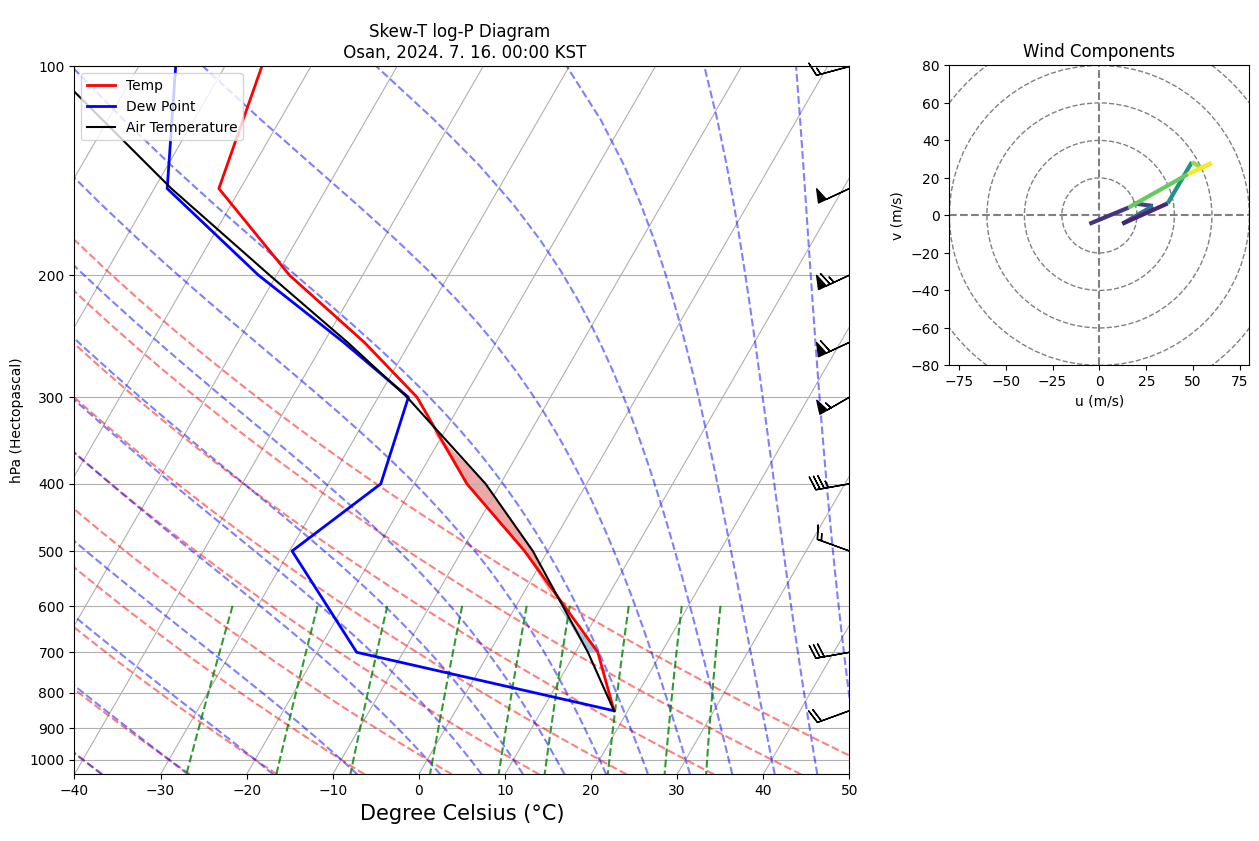

In [59]:
#mp.calc.components(속도, 방향)
import metpy.calc as mc
u, v = mc.wind_components(ws, wd)

#Library Import
from metpy.plots import SkewT
import matplotlib.pyplot as plt


#Plot SkewT
fig = plt.figure(figsize = (10, 10))
skew = SkewT(fig)

skew.plot(p, t, 'r', linewidth = 2,label = 'Temp') #기온 빨간선
skew.plot(p, td, 'b', linewidth = 2, label = 'Dew Point') #이슬점온도 파란선

skew.plot_barbs(p, u, v) #바람

# 상승하는 공기덩어리의 온도곡선 -> 검은 실선
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=1.5, label = 'Air Temperature')

#CIN과 CAPE 표시
skew.shade_cin(p, t, prof, td)
skew.shade_cape(p, t, prof)

#감률선
skew.plot_dry_adiabats() #건조 감률선 -  빨간 점선
skew.plot_moist_adiabats() #습윤 감률선 -  파란 점선
skew.plot_mixing_lines() #혼합비 - 녹색 점선

skew.ax.set_title('Skew-T log-P Diagram \n Osan, 2024. 7. 16. 00:00 KST') #제목
plt.xlabel('Degree Celsius (\u00B0C)', fontsize = 15) #x축값
plt.ylabel('hPa (Hectopascal)') #y축값

# 호도그래프 그리기
ax_hod = plt.axes((1, 0.55, 0.3, 0.3))
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, ws)  # 풍속에 따라 색상 변화
h.ax.set_title('Wind Components')
h.ax.set_xlabel('u (m/s)')
h.ax.set_ylabel('v (m/s)')

# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')

plt.show()


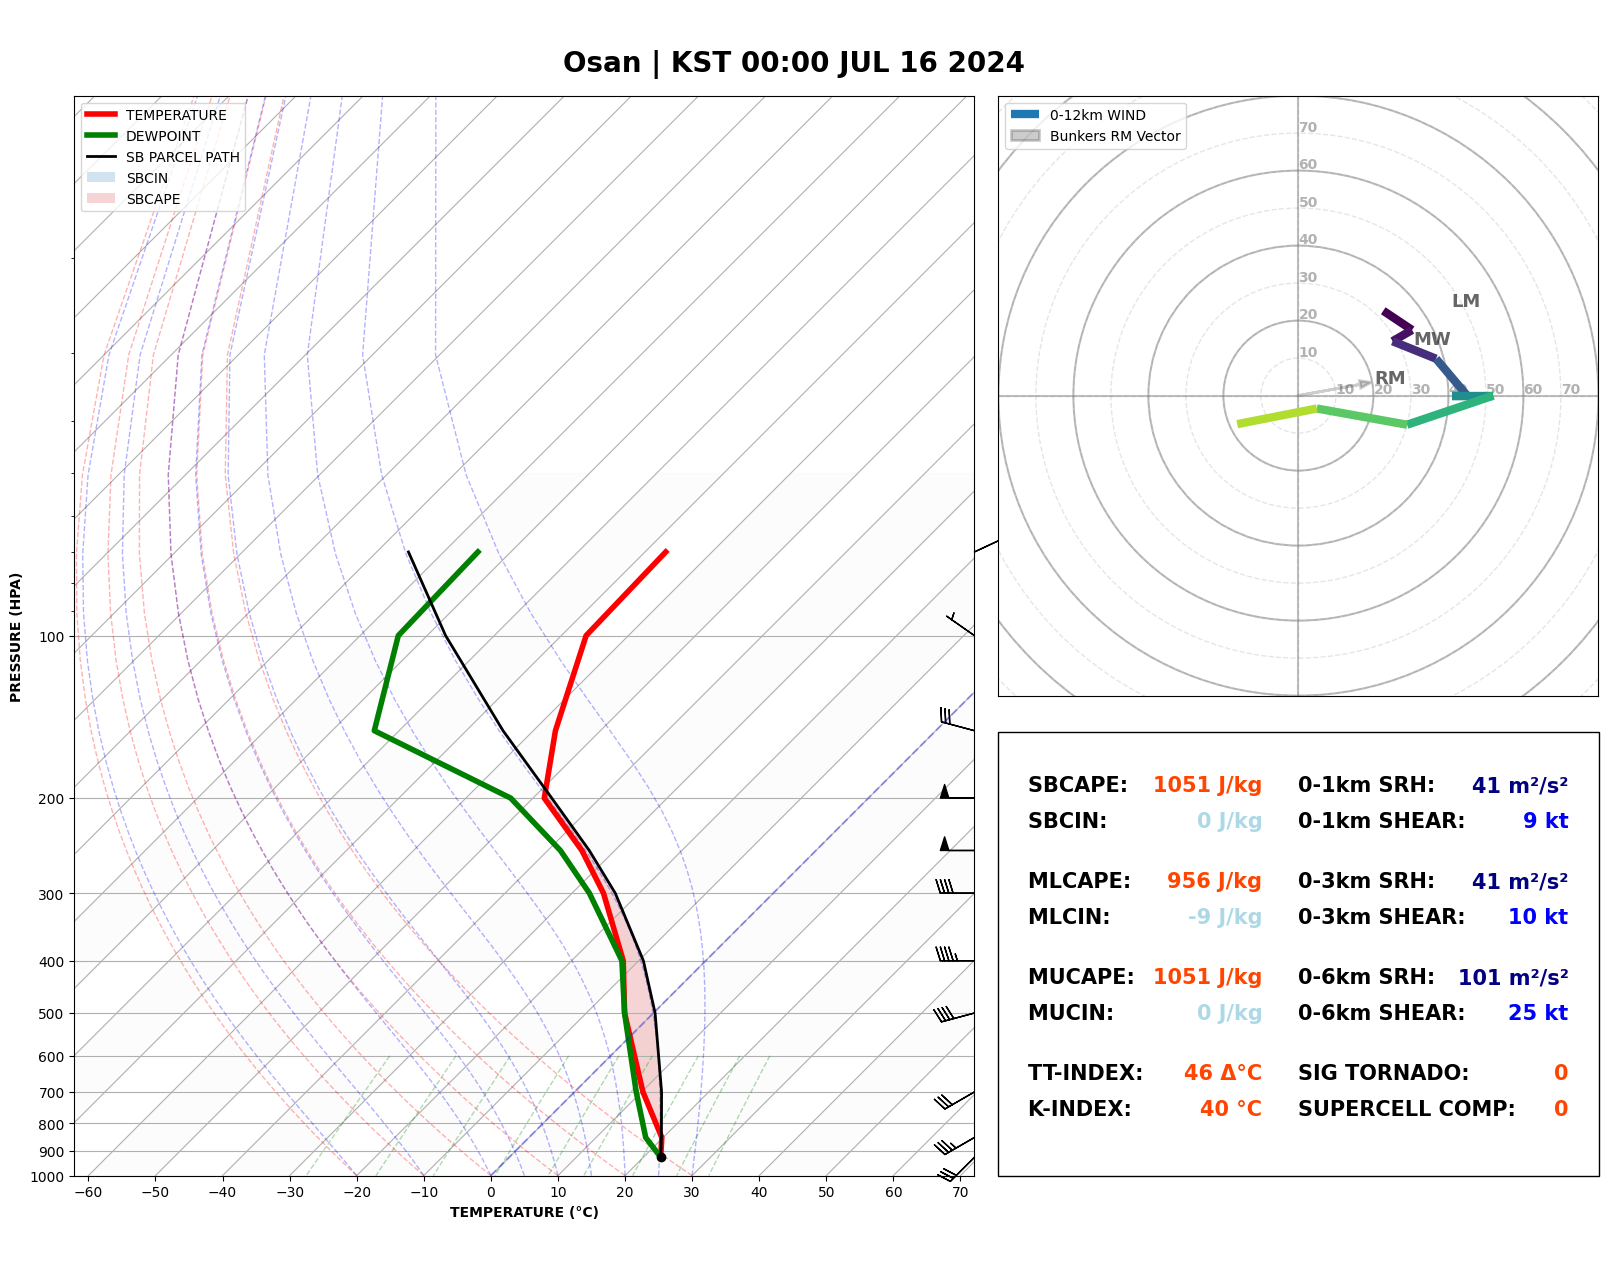

In [62]:
# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))


# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 10)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({t.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({p.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(0, 8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(p, t, 'r', lw=4, label='TEMPERATURE')
skew.plot(p, td, 'g', lw=4, label='DEWPOINT')

# Again we can use some simple Python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(1, 3, 1000) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='SB PARCEL PATH')

# Shade areas of CAPE and CIN
skew.shade_cin(p, t, prof, td, alpha=0.2, label='SBCIN')
skew.shade_cape(p, t, prof, alpha=0.2, label='SBCAPE')

# STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO
# INCREASE READABILITY
# Create a hodograph object: first we need to add an axis
# then we can create the Metpy Hodograph
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two separate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(u, v, c=z, linewidth=6, label='0-12km WIND')
# compute Bunkers storm motion so we can plot it on the hodograph!
RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left',
          fontsize=13, alpha=0.6)
h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black',
           alpha=0.2, label='Bunkers RM Vector',
           length_includes_head=True, head_width=2)

# STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
# First we want to actually add values of data to the plot for easy viewing
# To do this, let's first add a simple rectangle using Matplotlib's 'patches'
# functionality to add some simple layout for plotting calculated parameters
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.37,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])

# Now let's take a moment to calculate some simple severe-weather parameters using
# metpy's calculations
# Here are some classic severe parameters!
kindex = mpcalc.k_index(p, t, td)
total_totals = mpcalc.total_totals_index(p, t, td)

# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, t, td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, t, td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, t, prof, depth=50 * units.hPa)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, t, td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, t, td, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(t[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, t, td)
# Compute SRH
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# There is a lot we can do with this data operationally, so let's plot some of
# these values right on the plot, in the box we made
# First lets plot some thermodynamic parameters
plt.figtext(0.58, 0.37, 'SBCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.37, f'{sbcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.34, 'SBCIN: ', weight='bold',
            fontsize=15, color='black', ha='left')
plt.figtext(0.71, 0.34, f'{sbcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.29, 'MLCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.29, f'{mlcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.26, 'MLCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.26, f'{mlcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.21, 'MUCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.21, f'{mucape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.18, 'MUCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.18, f'{mucin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.13, 'TT-INDEX: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.13, f'{total_totals:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.10, 'K-INDEX: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.10, f'{kindex:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')

# now some kinematic parameters
plt.figtext(0.73, 0.37, '0-1km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.37, f'{total_helicity1:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.34, '0-1km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.34, f'{bshear1:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.29, '0-3km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.29, f'{total_helicity3:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.26, '0-3km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.26, f'{bshear3:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.21, '0-6km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.21, f'{total_helicity6:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.18, '0-6km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.18, f'{bshear6:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.13, 'SIG TORNADO: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.13, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')
plt.figtext(0.73, 0.10, 'SUPERCELL COMP: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.10, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')

# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# add a quick plot title, this could be automated by
# declaring a station and datetime variable when using
# realtime observation data from Siphon.
plt.figtext(0.45, 0.97, 'Osan | KST 00:00 JUL 16 2024',
            weight='bold', fontsize=20, ha='center')

# Show the plot
plt.show()